# Notes

- TF-DF is going to the right node if the condition is met
    - if value > 3 go to right node
    - vs the others trees .... if value < 3 go to left
        - It's the same thing, but ask from different angle
        
- TF-DF can automatically convert categorical values into numerical one
    - this will not work with dtreeviz by default, because dtreeviz is working with the raw training set and doesn't have access to the numerical values (for those categorical features)    

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import sys
import os
if 'google.colab' in sys.modules:
  !pip install -q -U dtreeviz
  !pip install -q -U tensorflow_decision_forests

# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

from dtreeviz.models.tensorflow_decision_tree import ShadowTensorflowTree

import tensorflow_decision_forests as tf
from tensorflow_decision_forests.tensorflow.core import Task

import pandas as pd

from sklearn.model_selection import train_test_split
from collections import defaultdict

from dtreeviz.trees import *

# Data preprocessing

In [3]:
random_state = 1234
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes

dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes
features = ["Pclass", "Age", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]

target = "Survived"

In [4]:
dataset[features + [target]]

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label,Survived
0,3,22.000000,7.2500,1,-1,2,0
1,1,38.000000,71.2833,0,81,0,1
2,3,26.000000,7.9250,0,-1,2,1
3,1,35.000000,53.1000,0,55,2,1
4,3,35.000000,8.0500,1,-1,2,0
...,...,...,...,...,...,...,...
886,2,27.000000,13.0000,1,-1,2,0
887,1,19.000000,30.0000,0,30,2,1
888,3,29.699118,23.4500,0,-1,2,0
889,1,26.000000,30.0000,1,60,0,1


# Classification

## Model training

In [5]:
random_seed = 1234
train, test = train_test_split(dataset[features + [target]], train_size=0.9, stratify=dataset.Survived, random_state=random_seed)
train_ds = tf.keras.pd_dataframe_to_tf_dataset(train, label=target)
test_ds = tf.keras.pd_dataframe_to_tf_dataset(test, label=target)


In [6]:
model = tf.keras.RandomForestModel(num_trees=1, max_depth=4, random_seed = random_seed, bootstrap_training_dataset=False, sampling_with_replacement=False)


Use /var/folders/yp/rczwnkhn6nn9mfcf0bgc61jh0000gn/T/tmpldp6wmb0 as temporary training directory


In [7]:
model.fit(train_ds)


Reading training dataset...
Training dataset read in 0:00:03.612845. Found 801 examples.
Training model...
Model trained in 0:00:00.011448
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [8]:
model.compile(metrics=["accuracy"])


In [9]:
print(model.evaluate(test_ds))


1/1 [==============================] - 0s 475ms/step - loss: 0.0000e+00 - accuracy: 0.8556
[0.0, 0.855555534362793]


## Model metadata discovery

### Prepare for HTML

In [10]:
# print(tf.model_plotter.plot_model(model, tree_idx=0))

## dtreeviz - model setup & interpretation

In [39]:
dtreeviz_model = get_model(model, tree_index=0, 
                             x_data=train[features], 
                             y_data=train[target], 
                             feature_names=features, 
                             target_name=target,
                             class_names=[0, 1])

### Tree structure

/Users/tudor.lapusan/Documents/workspace/personal/dtreeviz/notebooks/../dtreeviz/models/tensorflow_decision_tree.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.thresholds = np.array(thresholds)


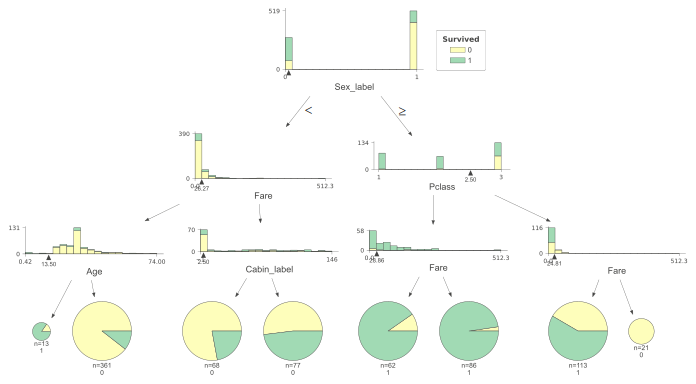

In [40]:
dtreeviz(dtreeviz_model)

### Leaf samples

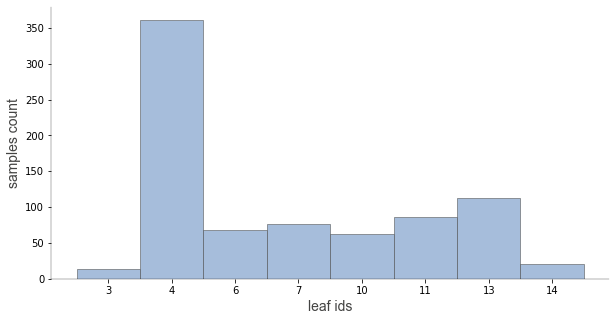

In [41]:
viz_leaf_samples(dtreeviz_model)

#### Leaf samples by class

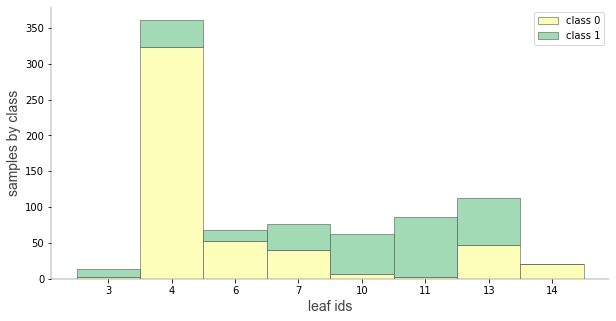

In [14]:
ctreeviz_leaf_samples(dtreeviz_model)

### Describe node samples

In [15]:
describe_node_sample(dtreeviz_model, node_id=4)

,Pclass,Age,Fare,Sex_label,Cabin_label,Embarked_label
count,361.000000,361.000000,361.000000,361.0,361.000000,361.000000
mean,2.739612,30.202548,10.402825,1.0,2.132964,1.678670
std,0.498675,9.744753,5.467339,0.0,19.136615,0.672321
min,1.000000,15.000000,0.000000,1.0,-1.000000,0.000000
25%,3.000000,24.000000,7.750000,1.0,-1.000000,2.000000
50%,3.000000,29.699118,8.050000,1.0,-1.000000,2.000000
75%,3.000000,33.000000,13.000000,1.0,-1.000000,2.000000
max,3.000000,74.000000,26.250000,1.0,141.000000,2.000000


### Explain prediction path

In [16]:
X = train[features].iloc[10]
X

Pclass             3.00
Age               38.00
Fare               7.05
Sex_label          1.00
Cabin_label       -1.00
Embarked_label     2.00
Name: 465, dtype: float64

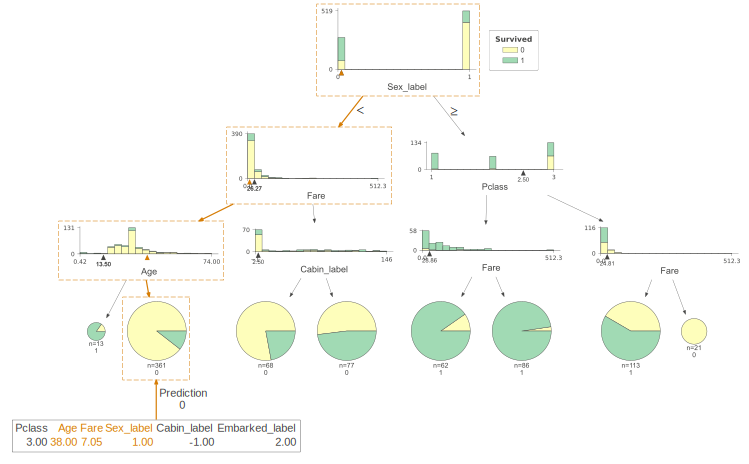

In [17]:
dtreeviz(dtreeviz_model, X=X)

In [18]:
print(explain_prediction_path(dtreeviz_model, X, explanation_type="plain_english"))

13.5 <= Age 
Fare < 26.27
Sex_label not in {0}  



# Regression

## Model training

In [19]:
random_seed = 1234
features_reg = ["Pclass", "Survived", "Fare", "Sex_label", "Cabin_label", "Embarked_label"]

target_reg = "Age"
train_reg, test_reg = train_test_split(dataset[features_reg + [target_reg]], train_size=0.8, random_state=random_seed)


In [20]:
train_reg_ds = tf.keras.pd_dataframe_to_tf_dataset(train_reg, label=target_reg, task=Task.REGRESSION)
test_reg_ds = tf.keras.pd_dataframe_to_tf_dataset(test_reg, label=target_reg, task=Task.REGRESSION)

In [21]:
model_reg = tf.keras.RandomForestModel(num_trees=4, max_depth=4, random_seed = random_seed, bootstrap_training_dataset=False, sampling_with_replacement=False, task=Task.REGRESSION)
model_reg.fit(train_reg_ds)



Use /var/folders/yp/rczwnkhn6nn9mfcf0bgc61jh0000gn/T/tmp7p_vwnqt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.213590. Found 712 examples.
Training model...
Model trained in 0:00:00.013440
Compiling model...
Model compiled.


In [22]:
print(model_reg.evaluate(test_reg_ds))


1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00
0.0


In [23]:
model_reg

## Model metadata discovery

In [24]:
# print(tf.model_plotter.plot_model(model_reg, tree_idx=0))

## dtreeviz - model setup & interpretation

In [25]:
dtreeviz_reg_model = get_model(model_reg, tree_index=0, 
                             x_data=train_reg[features_reg], 
                             y_data=train_reg[target_reg], 
                             feature_names=features_reg, 
                             target_name=target_reg)

In [26]:
# tf_reg_shadow = ShadowTensorflowTree(model_reg, tree_index=0, 
#                              x_data=train_reg[features_reg], 
#                              y_data=train_reg[target_reg], 
#                              feature_names=features_reg, 
#                              target_name=target_reg,
#                              class_names=[0, 1])

### Tree structure

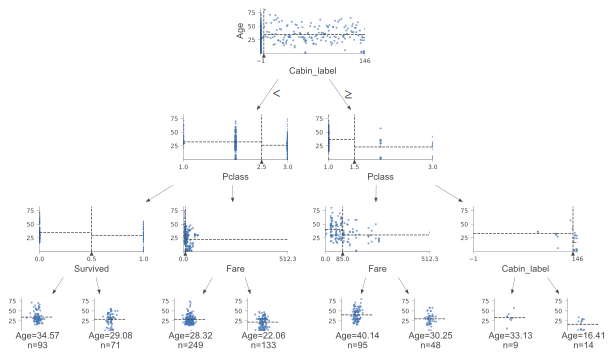

In [27]:
dtreeviz(dtreeviz_reg_model)

### Prediction path

In [28]:
X = train_reg[features_reg].iloc[3]
X

Pclass             3.0000
Survived           1.0000
Fare              56.4958
Sex_label          1.0000
Cabin_label       -1.0000
Embarked_label     2.0000
Name: 643, dtype: float64

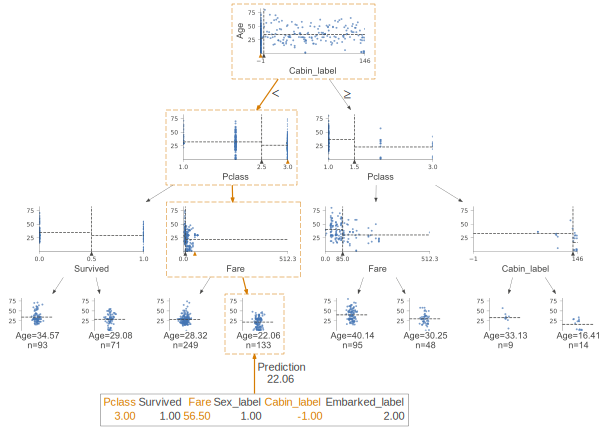

In [30]:
dtreeviz(dtreeviz_reg_model, X=X)

### Leaf  samples

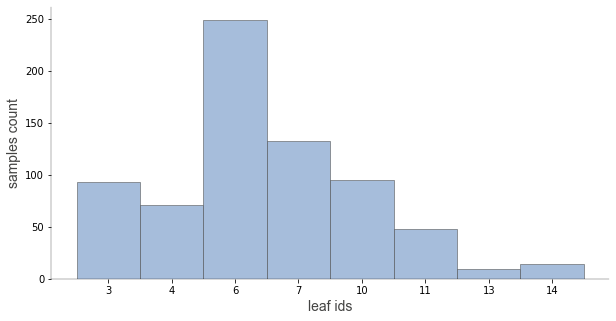

In [31]:
viz_leaf_samples(dtreeviz_reg_model)

### Describe node samples

In [32]:
describe_node_sample(dtreeviz_reg_model, node_id=4)

,Pclass,Survived,Fare,Sex_label,Cabin_label,Embarked_label
count,71.000000,71.0,71.000000,71.000000,71.0,71.000000
mean,1.774648,1.0,44.209215,0.197183,-1.0,1.633803
std,0.420788,0.0,69.307625,0.400704,0.0,0.779000
min,1.000000,1.0,10.500000,0.000000,-1.0,0.000000
25%,2.000000,1.0,15.875000,0.000000,-1.0,2.000000
50%,2.000000,1.0,26.000000,0.000000,-1.0,2.000000
75%,2.000000,1.0,33.000000,0.000000,-1.0,2.000000
max,2.000000,1.0,512.329200,1.000000,-1.0,2.000000


### Explain prediction path

In [34]:
X = train_reg[features_reg].iloc[10]
X

Pclass            3.00
Survived          0.00
Fare              7.25
Sex_label         1.00
Cabin_label      -1.00
Embarked_label    2.00
Name: 470, dtype: float64

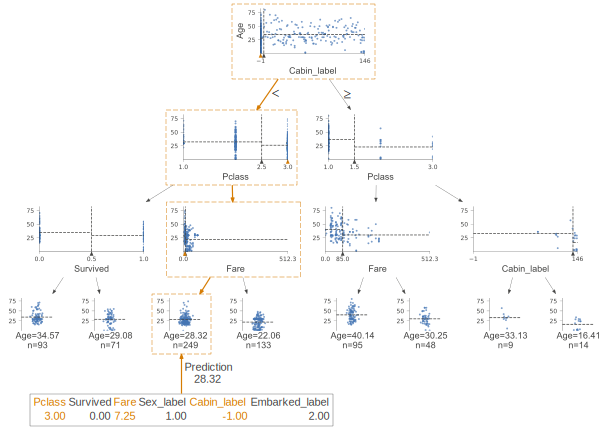

In [35]:
dtreeviz(dtreeviz_reg_model, X=X)

In [36]:
print(explain_prediction_path(dtreeviz_reg_model, X, explanation_type="plain_english"))

2.5 <= Pclass 
Fare < 9.71
Cabin_label < 3.5



### Leaf targets

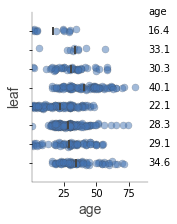

In [37]:
viz_leaf_target(dtreeviz_reg_model)